# Low-level API

The `nxviz` low level API is one that provides the most flexibility for constructing rational graph visualizations.

As always, with rational graph visualizations,
there is a process involved that helps us compose together beautiful visualizations.
We first concern ourselves with the node placement
using the layout functions.
Then, we concern ourselves with data-driven visual styling of the nodes.
After that, we figure out how to draw edges (whether as lines or bezier curves)
and style them according to data.

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

## Example

As an example, let's see how we make can make customizations to the Circos plot by using the low-level API.

For some of these things, we might be able to accomplish them using the higher level API,
but we will intentionally show the low-level way of handling these customizations
so that you can have a feel for how you can implement low-level customizations.

In [2]:
from random import choice

import networkx as nx
import numpy as np

G = nx.erdos_renyi_graph(n=71, p=0.1)
for n, d in G.nodes(data=True):
    G.nodes[n]["group"] = choice(["a", "b", "c"])
    G.nodes[n]["value"] = np.random.exponential()

np.random.seed(44)
for u, v, d in G.edges(data=True):
    G.edges[u, v]["edge_value"] = np.random.exponential()

## Node and Edge Table

The node and edge tables are the low-level data structures that are used in creating network visualizations.
These are pandas DataFrames.

In [3]:
from nxviz import utils

nt = utils.node_table(G)
nt.head()

/home/mauricio/miniconda3/envs/dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


,group,value
0,a,0.830888
1,c,0.502116
2,a,0.093001
3,c,0.093251
4,a,0.896266


The node table is indexed by node ID, and all of the metadata attributes are stored as columns.

In [4]:
et = utils.edge_table(G)
et.head()

,edge_value,source,target
0,1.800854,0,1
1,1.800854,1,0
2,0.110704,0,2
3,0.110704,2,0
4,1.365083,0,7


For the edge table, the "source" and "target" columns are the node IDs in the node table.
Every other column is a metadata field.
The index carries no semantic meaning here.

## Circos layout

Following the principles of rational graph visualization,
we start by declaring the layout that we want.
Since in our example we'll be using the Circos plot layout,
let's start by obtaining the (x, y) coordinate positions of each node that we want to plot.

The `nxviz.layouts` module contains the circos plot layout function that we'll want.
Underneath the hood, it uses pandas' group-by and sorting functionality
to get nodes into the correct order that we want.
If you wish to group and sort in a customized fashion,
then you'll have to implement the functionality yourself.

In [5]:
from nxviz import layouts

pos = layouts.circos(nt, group_by="group")

## Node styling

Next, we concern ourselves with the styling of the nodes.
Here, the `nxviz.encodings` submodule becomes useful for us.

When drawing nodes, their color, transparency, and size can be most naturally mapped to data.

- Transparency requires that a _quantitative_ value be mappable to the interval (0, 1).
- Size requires that a _quantitative_ value be mappable to the positive floats (0, +inf).
- Color is the trickiest of them all:
    - A categorical variable should be mapped to a categorical colormap.
    - A continuous variable should be mapped to a continuous colormap.

The choice of colormap is always going to be dependent on the user.
If you're looking for a guide on how to choose colormaps,
the [Points of View][pov] guide to colors is a very good resource to start with.

[pov]: http://blogs.nature.com/methagora/2013/07/data-visualization-points-of-view.html

How do we handle styling of nodes?
The primary way of doing so is to have a Python function
that maps from the node table's column of values (passed in as a pandas Series)
to any color specification that matplotlib can handle:

- Strings: "black", "yellow", "blue", etc.
- RGB(A): `(0.1, 0.8, 0.3, 0.5)`
- Hexadecimal: `#FFFFFF`, `#000000`, `#A7C91F`

Here's two examples, one using a highly custom mapping, and the other using matplotlib's color maps.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

from nxviz import encodings as aes


def group_colormap(data: pd.Series):
    cmap = {"a": "black", "b": "blue", "c": "red"}
    return data.apply(lambda x: cmap.get(x))


def value_colormap(data: pd.Series):
    """Value colormap."""
    norm = plt.cm.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap("viridis")
    return data.apply(lambda x: cmap(norm(x)))


def node_size(data: pd.Series):
    return data.apply(np.sqrt)

We can now combine everything together, into something that basically reconstructs
`nodes.draw`.

In [7]:
import inspect

from nxviz import nodes, plots

print(inspect.getsource(nodes.draw))

def draw(
    G: nx.Graph,
    layout_func: Callable,
    group_by: Hashable,
    sort_by: Hashable,
    color_by: Hashable = None,
    alpha_by: Hashable = None,
    size_by: Hashable = None,
    layout_kwargs: Dict = {},
    encodings_kwargs: Dict = {},
    rescale_func=rescale,
    ax=None,
):
    """Draw nodes to matplotlib axes.

    ## Parameters

    - `G`: The graph to plot.
    - `layout_func`: One of the node layout functions from `nxviz.layout`.
    - `group_by`: Categorical attribute key to group nodes by.
    - `sort_by`: Quantitative or ordinal attribute key to sort nodes.
    - `color_by`: Node attribute key to color nodes by.
    - `alpha_by`: Quantitative node attribute key to set transparency.
    - `size_by`: Quantitative node attribute key to set node size.
    - `layout_kwargs`: Keyword arguments to pass
        to the appropriate layout function.
    - `encodings_kwargs`: A dictionary of kwargs
        to determine the visual properties of the node.
    - `linefun

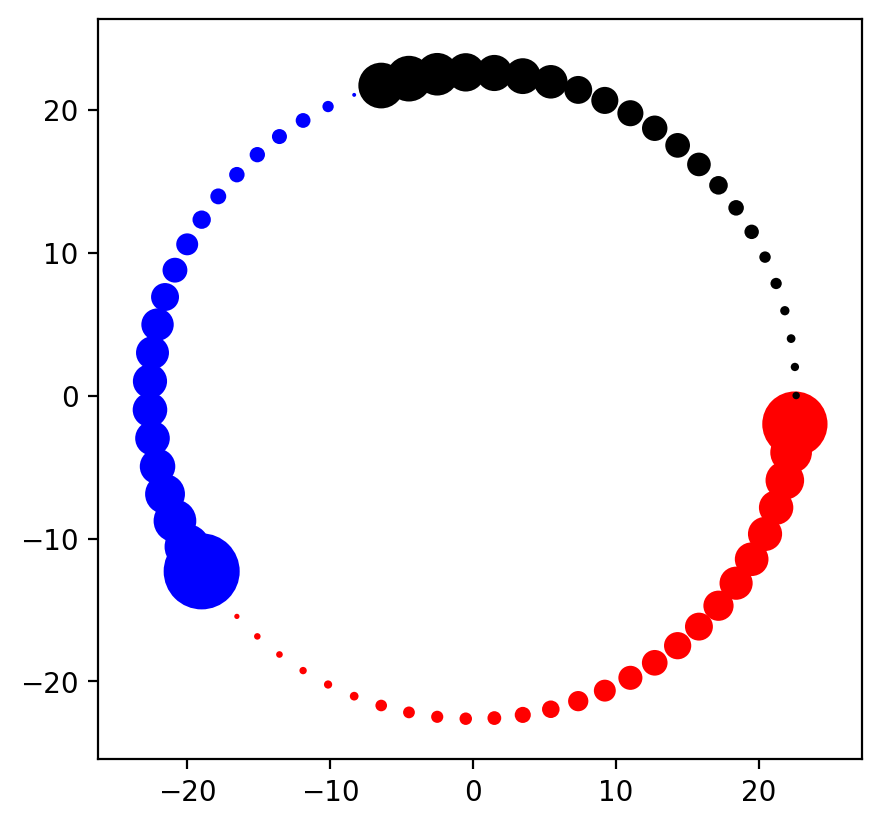

In [8]:
ax = plt.gca()

# Customize node styling
nt = utils.node_table(G)
pos = layouts.circos(nt, group_by="group", sort_by="value")
node_color = group_colormap(nt["group"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, "value")
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax.add_patch(patch)
plots.rescale(G)
plots.aspect_equal()

Voila! We now have a sonic hedgehog-style node layout! Pretty cool, isn't it?

## Adding in edges

Once the node layout is complete, customizing the edge styling is a matter of concerning ourselves with:

1. Line width
2. Transparency
3. Color

We could customize more, but these three are the most commonly-used for mapping data to style.
As with node layouts, we basically have to re-create `nxviz.edges.draw`
with customized data-to-style mapping functions.

In [9]:
from nxviz import edges

print(inspect.getsource(edges.draw))

def draw(
    G: nx.Graph,
    pos: Dict[Hashable, np.ndarray],
    lines_func: Callable,
    color_by: Hashable = None,
    node_color_by: Hashable = None,
    lw_by: Hashable = None,
    alpha_by: Hashable = None,
    ax=None,
    encodings_kwargs: Dict = {},
    **linefunc_kwargs,
):
    """Draw edges to matplotlib axes.

    ## Parameters

    - `G`: A NetworkX graph.
    - `pos`: A dictionary mapping for x,y coordinates of a node.
    - `lines_func`: One of the line drawing functions from `nxviz.lines`
    - `color_by`: Categorical or quantitative edge attribute key to color edges by.
        There are two special value for this parameter
        when using directed graphs:
        "source_node_color" and "target_node_color".
        If these values are set, then `node_color_by` also needs to be set.
    - `node_color_by`: Node metadata attribute key
        that has been used to color nodes.
    - `node_color_by`: Node metadata attribute key that has been used to
        color no

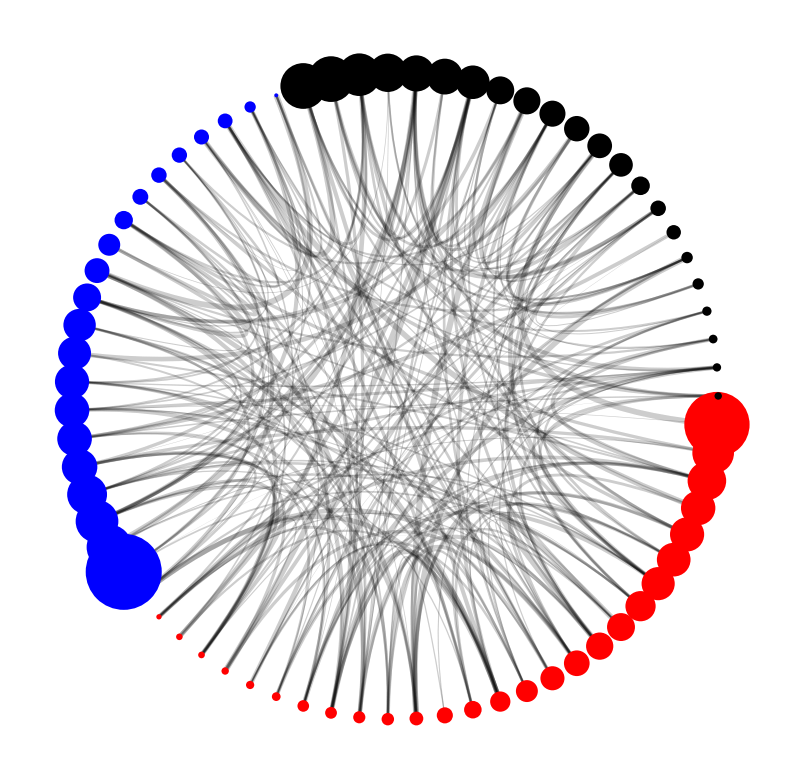

In [10]:
from nxviz import lines

# Customize node styling
ax = plt.gca()

nt = utils.node_table(G)
pos = layouts.circos(nt, group_by="group", sort_by="value")
node_color = group_colormap(nt["group"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, "value")
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax.add_patch(patch)

# Customize edge styling
et = utils.edge_table(G)
edge_color = edges.edge_colors(et, nt=None, color_by=None, node_color_by=None)
lw = np.sqrt(et["edge_value"])
alpha = edges.transparency(et, alpha_by=None)
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=lw, aes_kw={"fc": "none"}
)
for patch in patches:
    ax.add_patch(patch)

plots.rescale(G)
plots.aspect_equal()
plots.despine()

Looking at the plot, we might find that expressing the edges' `edge_value` as line width might not be that effective. Instead, we might want to express it using alpha.

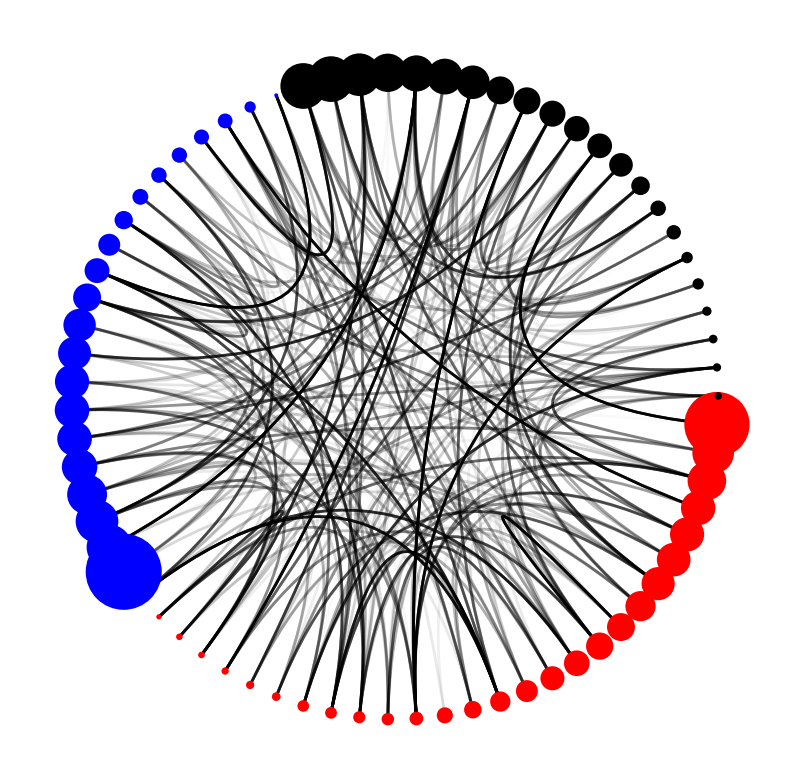

In [11]:
from nxviz import lines

# Customize node styling
ax = plt.gca()

nt = utils.node_table(G)
pos = layouts.circos(nt, group_by="group", sort_by="value")
node_color = group_colormap(nt["group"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, "value")
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax.add_patch(patch)

# Customize edge styling
et = utils.edge_table(G)
edge_color = edges.edge_colors(et, nt=None, color_by=None, node_color_by=None)
lw = edges.line_width(et, lw_by=None)
alpha = edges.transparency(et, alpha_by="edge_value")
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=lw, aes_kw={"fc": "none"}
)
for patch in patches:
    ax.add_patch(patch)

plots.rescale(G)
plots.aspect_equal()
plots.despine()

Looking at this plot, it's a lot easier for us to see the important edges (as visualized by the alpha value).

## Conclusion

Throughout this notebook, we dropped down from the mid-level API to the low-level API,
where we get to customize node and edge styling to our heart's content.
The patterns are easy to follow.
For nodes, we customize the **size, color and transparency**.
For edges we customize the **line width, color, and transparency**.
We can then compose them together into the plots we see above.